## Histogram

In [11]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

### Connection to sqlite3

In [12]:
conn = sqlite3.connect("../ex00/data/checking-logs.sqlite")

In [13]:
pd.read_sql("PRAGMA table_info(checker);", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,index,INTEGER,0,None,0
1,1,status,TEXT,0,None,0
2,2,success,INTEGER,0,None,0
3,3,timestamp,TIMESTAMP,0,None,0
4,4,numTrials,INTEGER,0,None,0
5,5,labname,TEXT,0,None,0
6,6,uid,TEXT,0,None,0


### Get data and change 

In [14]:
query = """ 
SELECT timestamp
FROM checker
WHERE uid LIKE 'user_%';
"""
df = pd.read_sql(query, conn)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['date'] = df['timestamp'].dt.date 
df['working_days'] = df['timestamp'].dt.weekday
df['day_type'] = df['working_days'].apply(lambda x: 'working_days' if x < 5 else 'weekend')
df

,timestamp,hour,date,working_days,day_type
0,2020-04-17 05:19:02.744528,5,2020-04-17,4,working_days
1,2020-04-17 05:22:35.249331,5,2020-04-17,4,working_days
2,2020-04-17 05:22:45.549397,5,2020-04-17,4,working_days
3,2020-04-17 05:34:14.691200,5,2020-04-17,4,working_days
4,2020-04-17 05:34:24.422370,5,2020-04-17,4,working_days
...,...,...,...,...,...
3202,2020-05-21 20:19:06.872761,20,2020-05-21,3,working_days
3203,2020-05-21 20:22:41.785725,20,2020-05-21,3,working_days
3204,2020-05-21 20:22:41.877806,20,2020-05-21,3,working_days
3205,2020-05-21 20:37:00.129678,20,2020-05-21,3,working_days


In [15]:
commit_counts = df.groupby(['day_type', 'hour']).size().reset_index(name='count')
commit_counts

,day_type,hour,count
0,weekend,0,6
1,weekend,1,6
2,weekend,3,1
3,weekend,5,2
4,weekend,7,16
5,weekend,8,28
6,weekend,9,22
7,weekend,10,28
8,weekend,11,118
9,weekend,12,57


In [16]:
working_days = commit_counts[commit_counts['day_type'] == 'working_days'][['hour', 'count']].rename(columns={'count': 'working_days'})
weekend = commit_counts[commit_counts['day_type'] == 'weekend'][['hour', 'count']].rename(columns={'count': 'weekend'})

In [17]:
hours = pd.DataFrame({'hour': range(24)})
merged = hours.merge(working_days, on='hour', how='left').merge(weekend, on='hour', how='left').fillna(0)
merged

,hour,working_days,weekend
0,0,6.0,6.0
1,1,0.0,6.0
2,2,0.0,0.0
3,3,2.0,1.0
4,4,0.0,0.0
5,5,15.0,2.0
6,6,3.0,0.0
7,7,31.0,16.0
8,8,37.0,28.0
9,9,30.0,22.0


### Graph

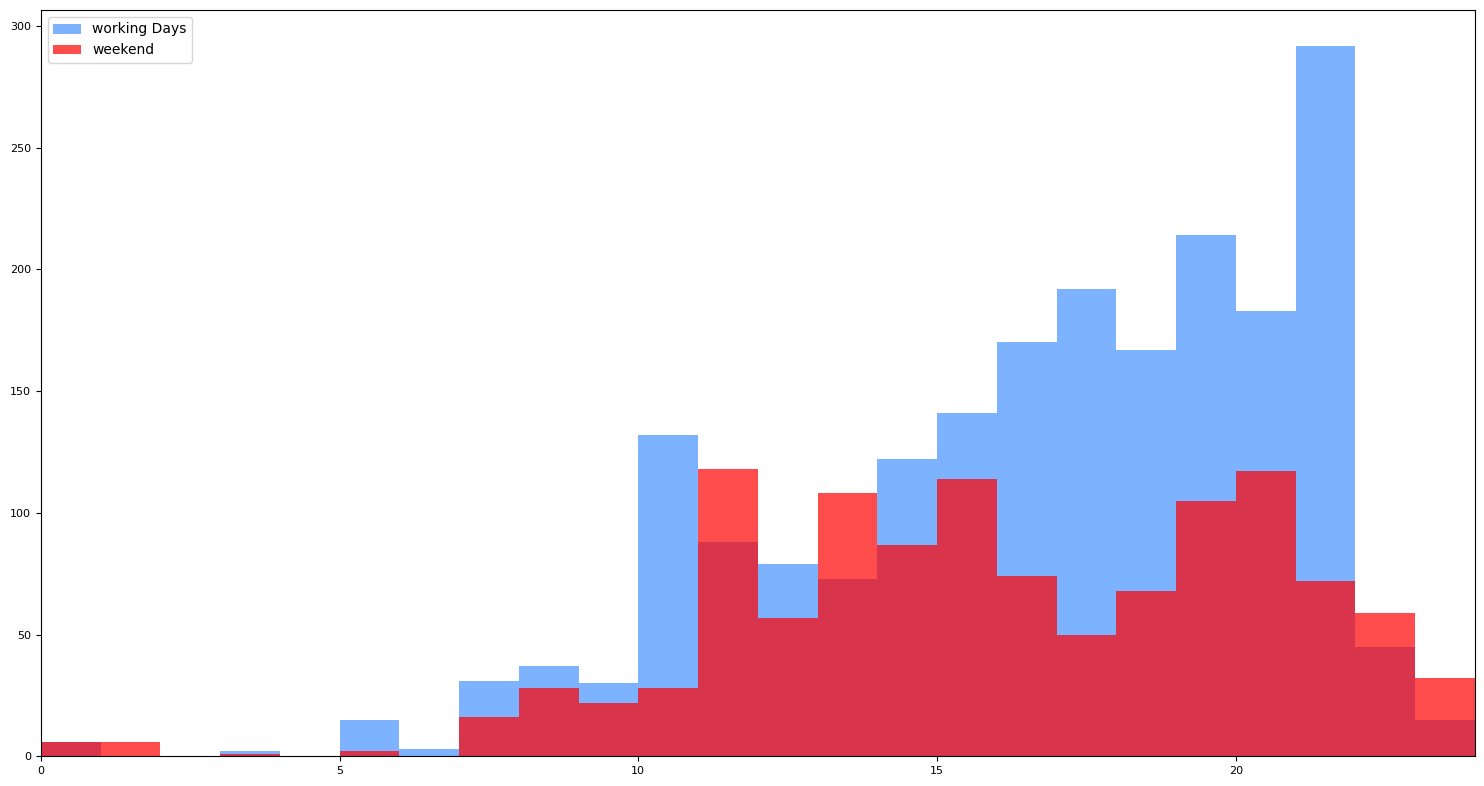

In [18]:
working_days = merged['working_days']
weekend = merged['weekend']
hours = merged['hour']

fig, ax = plt.subplots(figsize=(15, 8))

bins = range(25)

ax.hist(
    hours,
    weights=working_days,
    bins=bins,
    histtype='bar',
    label='working Days',
    alpha=0.7,
    color='#4692ff'
)

ax.hist(
    hours,
    weights=weekend,
    bins=bins,
    histtype='bar',
    label='weekend',
    alpha=0.7,
    color='red'
)

ax.legend()
plt.tight_layout()
ax.set_xlim(0, 24)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

### Conection closed

In [19]:
conn.close()

## Answer the questions

In [20]:
more_on_weekends = merged[merged['weekend'] > merged['working_days']].copy()
more_on_weekends['diff'] = more_on_weekends['weekend'] - more_on_weekends['working_days']
top4 = more_on_weekends.sort_values(by='diff', ascending=False)
top4[['hour', 'weekend', 'working_days']]

,hour,weekend,working_days
13,13,108.0,73.0
11,11,118.0,88.0
23,23,32.0,15.0
22,22,59.0,45.0
1,1,6.0,0.0


### The answers are: `11`, `13`, `22`, `23` 